Problem Statement

Predict whether a loan applicant will default (binary outcome) using historical application and credit bureau data.

Target variable: TARGET

1 → Default

0 → Non-default

This is a Probability of Default (PD) modeling problem.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline

In [ ]:
#Mount the Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/ML/ML projects/Home Credit Default Risk

/content/drive/MyDrive/ML/ML projects/Home Credit Default Risk


In [ ]:
df = pd.read_csv("application_train.csv")
#print(df.shape)
df = df.sample(n=30000)
df.head()


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
8609,110024,0,Cash loans,M,N,N,1,135000.0,755190.0,38686.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
60909,170639,0,Cash loans,M,N,N,2,225000.0,545040.0,26640.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
89188,203553,0,Cash loans,M,N,N,0,180000.0,1762110.0,46611.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
250454,389794,0,Cash loans,F,Y,Y,3,50850.0,284400.0,13387.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
135329,256960,0,Cash loans,M,Y,N,0,225000.0,497520.0,39438.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Checking class Imbalance
# Normalize converts count to %
df["TARGET"].value_counts(normalize=True)

,proportion
TARGET,
0,0.919067
1,0.080933


Default is 8% and Non-default is 92%.


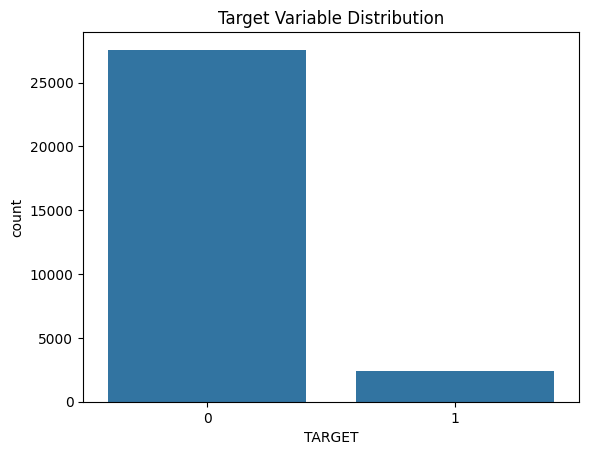

In [ ]:
sns.countplot(x='TARGET', data=df)
plt.title("Target Variable Distribution")
plt.show()

**Data Cleaning**

In [ ]:
missing_percent = df.isnull().mean() * 100
missing_percent.sort_values(ascending=False).head(10)


,0
COMMONAREA_AVG,70.003333
COMMONAREA_MODE,70.003333
COMMONAREA_MEDI,70.003333
NONLIVINGAPARTMENTS_MEDI,69.496667
NONLIVINGAPARTMENTS_MODE,69.496667
NONLIVINGAPARTMENTS_AVG,69.496667
FONDKAPREMONT_MODE,68.483333
LIVINGAPARTMENTS_AVG,68.360000
LIVINGAPARTMENTS_MEDI,68.360000
LIVINGAPARTMENTS_MODE,68.360000


Observations
Some variables have >50% missing



In [ ]:
# Seperate Target & Feature
x = df.drop(columns =['TARGET'])
y = df['TARGET']

In [ ]:
# Identify Variable Types
cat_features = x.select_dtypes(include=['object']).columns
num_features = x.select_dtypes(exclude=['object']).columns

In [ ]:
# Removing cols with missing value % > 60%
high_missing_cols = missing_percent[missing_percent > 60].index
df = df.drop(columns=high_missing_cols)

In [ ]:
df.shape

(30000, 105)

DATA PREPROCESSING & FEATURE ENGINEERING

| Type        | Example               | Treatment     |
| ----------- | --------------------- | ------------- |
| Numerical   | Income, Age           | Impute, scale |
| Categorical | Gender, Contract Type | Encode        |
| Binary      | Yes / No              | Map to 0/1    |


In [ ]:
# Separate numerical and categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(exclude=['object']).columns

# Check counts
print("Categorical features:", len(categorical_cols))
print("Numerical features:", len(numerical_cols))

Categorical features: 15
Numerical features: 90


In [ ]:
for col in numerical_cols :
  if df[col].isnull().sum() > 0:
    df[col + '_missing_flag'] = df[col].isnull().astype(int)

| Line                        | Meaning                   |
| --------------------------- | ------------------------- |
| `for col in numerical_cols` | Loop over numeric columns |
| `isnull().sum()`            | Check if missing exists   |
| `astype(int)`               | Convert True/False → 1/0  |

Missing flags allow the model to learn whether absence of information itself is predictive.

In [ ]:
# Median imputation

for col in numerical_cols:
  median_vlaue = df[col].median()
  df[col] = df[col].fillna(median_vlaue)

HANDLE CATEGORICAL VARIABLES

In [ ]:
# One-hot encoding for categorical data

df[categorical_cols] = df[categorical_cols].fillna('Missing')

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

| Argument          | Meaning                              |
| ----------------- | ------------------------------------ |
| `get_dummies`     | Converts categories into 0/1 columns |
| `drop_first=True` | Prevents multicollinearity           |
| New columns       | Each category becomes a feature      |


In [ ]:
df_encoded.shape

(30000, 256)

In [ ]:
df_encoded

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Missing,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
8609,110024,0,1,135000.0,755190.0,38686.5,675000.0,0.006629,-19128,365243,...,False,True,False,False,False,False,False,False,False,False
60909,170639,0,2,225000.0,545040.0,26640.0,450000.0,0.014464,-10375,-570,...,False,False,False,False,False,False,False,False,True,False
89188,203553,0,0,180000.0,1762110.0,46611.0,1575000.0,0.030755,-22227,365243,...,False,True,False,False,False,False,False,False,False,False
250454,389794,0,3,50850.0,284400.0,13387.5,225000.0,0.018029,-12364,-2184,...,False,True,False,False,False,False,False,False,False,False
135329,256960,0,0,225000.0,497520.0,39438.0,450000.0,0.046220,-8576,-536,...,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187928,317858,0,2,67500.0,355536.0,15790.5,270000.0,0.031329,-12601,-249,...,False,True,False,False,False,False,False,False,False,False
13713,115982,1,1,135000.0,746280.0,54436.5,675000.0,0.018029,-11724,-483,...,False,True,False,False,False,False,False,False,False,False
275426,419202,0,0,76500.0,526491.0,22131.0,454500.0,0.018801,-10624,-1824,...,False,True,False,False,False,False,False,False,False,False
7943,109261,0,0,76500.0,252000.0,25051.5,252000.0,0.014520,-9042,-1607,...,False,True,False,False,False,False,False,False,False,False


FEATURE ENGINEERING

In [ ]:
#Transform raw system variables into business-understandable features.

df_encoded['AGE_YEARS'] = -df_encoded['DAYS_BIRTH'] / 365
df_encoded['EMPLOYMENT_YEARS'] = -df_encoded['DAYS_EMPLOYED'] / 365
df_encoded['INCOME_PER_PERSON'] = (
    df_encoded['AMT_INCOME_TOTAL'] / df_encoded['CNT_FAM_MEMBERS']
)


In [ ]:
df_encoded['CREDIT_INCOME_RATIO'] = (
    df_encoded['AMT_CREDIT'] / df_encoded['AMT_INCOME_TOTAL']
)

In [ ]:
# Handle infinite values (division issues)
df_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)
df_encoded.fillna(0, inplace=True)

FEATURE SCALING (FOR LINEAR MODELS)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Separate SK_ID_CURR and TARGET from features to be scaled
X_data = df_encoded.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = df_encoded['TARGET']
sk_id_curr_series = df_encoded['SK_ID_CURR'] # Store SK_ID_CURR separately

# Scale only the features (excluding SK_ID_CURR)
x_scaled_array = scaler.fit_transform(X_data)

# Reconstruct X as a DataFrame with scaled features, preserving the original index
# This 'x_processed' DataFrame will be used for splitting
x_processed = pd.DataFrame(x_scaled_array, columns=X_data.columns, index=df_encoded.index)

TRAIN / VALIDATION / TEST SPLIT

| Dataset    | Purpose              |
| ---------- | -------------------- |
| Train      | Learn parameters     |
| Validation | Tune regularization  |
| Test       | Final unbiased check |



In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.model_selection import train_test_split

# Use the DataFrame with scaled features (x_processed) and target y for splitting
# This ensures that x_train, x_temp, y_train, y_temp retain their DataFrame/Series structure and indices
x_train, x_temp, y_train, y_temp = train_test_split(
    x_processed, y, # Use the DataFrame x_processed here
    test_size=0.30,
    stratify=y,
    random_state=42
)

In [ ]:
# Validation and Test

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

BASELINE LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Train logistic regression with L2 regularization

log_reg = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter= 1000)

log_reg.fit(x_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [ ]:
# start with moderate L2 regularization and tune C using validation data.

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
# Probalblity of default calculation

y_train_pred = log_reg.predict_proba(x_train)[:, 1]
y_val_pred = log_reg.predict_proba(x_val)[:, 1]


In [ ]:
train_auc = roc_auc_score(y_train, y_train_pred)
val_auc = roc_auc_score(y_val, y_val_pred)

print("Train AUC:", train_auc)
print("Validation AUC:", val_auc)


Train AUC: 0.7721663212435234
Validation AUC: 0.7222385327438519


Train AUC is slightly higher than Validation AUC. Means a balanced Model

GINI & KS

In [ ]:
gini_val = 2 *val_auc - 1
print("Validation Gini:", gini_val)

Validation Gini: 0.4444770654877037


In [ ]:
# KS Statistic

import numpy as np

def ks_statistic(y_true, y_prob):
    data = pd.DataFrame({'y': y_true, 'prob': y_prob})
    data = data.sort_values('prob')
    data['cum_good'] = (1 - data['y']).cumsum() / (1 - data['y']).sum()
    data['cum_bad'] = data['y'].cumsum() / data['y'].sum()
    return np.max(np.abs(data['cum_bad'] - data['cum_good']))

ks_val = ks_statistic(y_val, y_val_pred)
print("Validation KS:", ks_val)


Validation KS: 0.34495823325610553


Separation between good & bad customers

KS > 0.3 is considered decent

COEFFICIENT INTERPRETATION

In [ ]:
# Extract Coefficients

coefficients = pd.DataFrame({
    'Feature': df_encoded.drop('TARGET', axis=1).columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

coefficients.head(10)


,Feature,Coefficient
8,DAYS_EMPLOYED,1.064113
3,AMT_CREDIT,0.874450
12,FLAG_EMP_PHONE,0.696539
51,ELEVATORS_MEDI,0.573830
58,OBS_30_CNT_SOCIAL_CIRCLE,0.573761
54,LANDAREA_MEDI,0.473526
152,NAME_EDUCATION_TYPE_Secondary / secondary special,0.444620
149,NAME_EDUCATION_TYPE_Higher education,0.331427
38,NONLIVINGAREA_AVG,0.327578
45,LANDAREA_MODE,0.316737


In [ ]:
# logspace(-3, 2, 10) means 0.001 to 100
import numpy as np

C_values = np.logspace(-3, 2, 10)

In [ ]:
# We store performance for analysis.
# Initializes an empty list named train_auc_list, val_auc_list

train_auc_list = []
val_auc_list = []

In [ ]:
for C in C_values:
    model = LogisticRegression(
        penalty='l2',
        C=C,
        solver='liblinear',
        max_iter=1000
    )

    model.fit(x_train, y_train)

    train_pred = model.predict_proba(x_train)[:,1]
    val_pred = model.predict_proba(x_val)[:,1]

    train_auc_list.append(roc_auc_score(y_train, train_pred))
    val_auc_list.append(roc_auc_score(y_val, val_pred))

For each regularization level Train model measure in-sample performance and measure out-of-sample performance


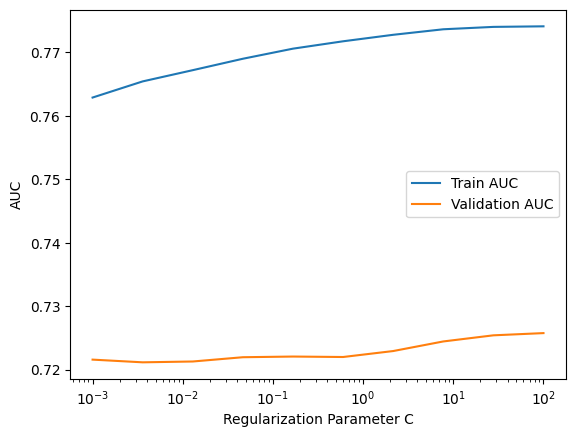

In [ ]:
import matplotlib.pyplot as plt

plt.plot(C_values, train_auc_list, label='Train AUC')
plt.plot(C_values, val_auc_list, label='Validation AUC')
plt.xscale('log')
plt.xlabel('Regularization Parameter C')
plt.ylabel('AUC')
plt.legend()
plt.show()

| Region         | What it means |
| -------------- | ------------- |
| Left (low C)   | Underfitting  |
| Middle         | Optimal       |
| Right (high C) | Overfitting   |



In [ ]:
# The optimal C balances generalization and stability rather than maximizing training performance.

# Select C where validation AUC peaks and the train–validation gap is minimal.

best_c = C_values[np.argmax(val_auc_list)]
print("Best C:", best_c)

Best C: 100.0


In [ ]:
# FINAL L2 MODEL WITH OPTIMAL C

final_l2_model = LogisticRegression(
    penalty='l2',
    C=best_c,
    solver='liblinear',
    max_iter = 1000)

final_l2_model.fit(x_train, y_train)

LogisticRegression(C=np.float64(100.0), max_iter=1000, solver='liblinear')

ELASTIC NET
Elastic Net is preferred when features are correlated and interpretability is required.

In [ ]:
elastic_model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,
    C=best_c,
    max_iter=2000
)

elastic_model.fit(x_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=np.float64(100.0), l1_ratio=0.5, max_iter=2000,
                   penalty='elasticnet', solver='saga')

In [ ]:
l2_val_auc = roc_auc_score(y_val, final_l2_model.predict_proba(x_val)[:,1])
elastic_val_auc = roc_auc_score(y_val, elastic_model.predict_proba(x_val)[:,1])

print("L2 Validation AUC:", l2_val_auc)
print("Elastic Net Validation AUC:", elastic_val_auc)


L2 Validation AUC: 0.7257396858460688
Elastic Net Validation AUC: 0.7211259485195656


COEFFICIENT SPARSITY CHECK

A coefficient sparsity check in an ML model verifies how many feature weights are zero (or near zero), indicating feature importance; this is crucial for high-dimensional data, improving interpretability, reducing overfitting, and boosting efficiency, often achieved via L1 regularization (LASSO) which pushes irrelevant coefficients to zero, making the model "sparse".


In [ ]:
# Features have coefficient equal to zero


np.sum(elastic_model.coef_[0] == 0)


np.int64(3)

3 feaatures have coeff equal or near to 0

In [ ]:
# Final feature count used by the model - (259-3)

selected_features = df_encoded.drop('TARGET', axis=1).columns[
    elastic_model.coef_[0] != 0
]

len(selected_features)

256

FINAL TEST EVALUATION, STABILITY, CALIBRATION & PRODUCTION READINESS

In [ ]:
# Test data is used once, at the very end, to estimate true out-of-sample performance.

y_test_pred = final_l2_model.predict_proba(x_test)[:, 1]

test_auc = roc_auc_score(y_test, y_test_pred)
test_gini = 2 * test_auc - 1
test_ks = ks_statistic(y_test, y_test_pred)

print("Test AUC:", test_auc)
print("Test Gini:", test_gini)
print("Test KS:", test_ks)


Test AUC: 0.7401979669266903
Test Gini: 0.48039593385338053
Test KS: 0.37035305120411505


In [ ]:
Clibaration

In [ ]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
    y_test,
    y_test_pred,
    n_bins=10
)


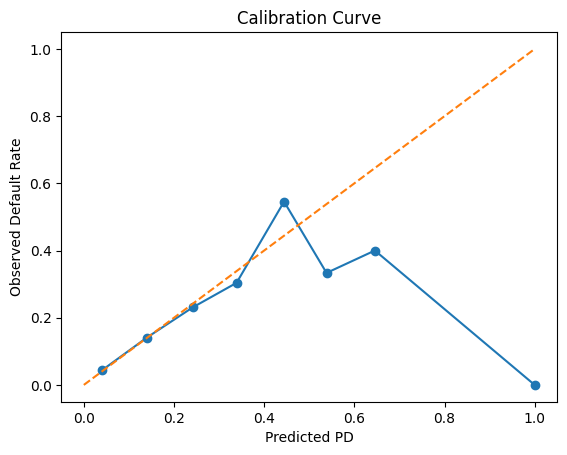

In [ ]:
plt.figure()
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("Predicted PD")
plt.ylabel("Observed Default Rate")
plt.title("Calibration Curve")
plt.show()


The model is well calibrated for low and medium PD segments, which cover most of the portfolio. However, in the high-risk region, observed defaults exceed predicted PD, indicating underestimation of risk. At extreme PD values, calibration becomes unstable due to limited observations.

Apply calibration techniques such as Platt scaling or isotonic regression and validate calibration using out-of-time data.

The Population Stability Index (PSI) is a key metric in model monitoring that quantifies the difference between the distribution of a variable in a current dataset versus a baseline (training) dataset, helping detect significant changes (model drift) in the population characteristics, crucial for maintaining model accuracy, especially in credit scoring and risk management.

| PSI      | Meaning        |
| -------- | -------------- |
| < 0.1    | Stable         |
| 0.1–0.25 | Moderate shift |
| > 0.25   | High risk      |




In [ ]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(
    final_l2_model,
    method='sigmoid',
    cv=5
)

calibrated_model.fit(x_train, y_train)


CalibratedClassifierCV(cv=5,
                       estimator=LogisticRegression(C=np.float64(100.0),
                                                    max_iter=1000,
                                                    solver='liblinear'))

In [ ]:
#PSI function

def calculate_psi(expected, actual, bins=10):
    breakpoints = np.percentile(expected, np.linspace(0, 100, bins+1))

    expected_counts = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_counts = np.histogram(actual, bins=breakpoints)[0] / len(actual)

    psi = np.sum(
        (actual_counts - expected_counts) *
        np.log(actual_counts / expected_counts)
    )
    return psi


In [ ]:
# Calculate PSI

# Low PSI confirms model stability over time

psi_value = calculate_psi(
    final_l2_model.predict_proba(x_train)[:,1],
    final_l2_model.predict_proba(x_test)[:,1]
)

print("PSI:", psi_value)


PSI: 0.0024158880087725874


PSI < 1 Model is stable

MODEL DECISION & JUSTIFICATION

Why choose this model?

Stable AUC across datasets;
Strong KS separation;
Intuitive coefficients;
Regularized & interpretable;
Calibrated PDs;
Monitorable via PSI

I selected the final model based on stability, interpretability, and regulatory acceptance rather than marginal AUC gains.

MODEL BENCHMARKING - GBM MODEL IMPLEMENTATION

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


In [ ]:
gbm_model = GradientBoostingClassifier(
    n_estimators=200,      # number of trees
    learning_rate=0.05,    # slow learning = stability
    max_depth=3,           # shallow trees (very important)
    min_samples_leaf=200,  # avoids micro-segmentation
    subsample=0.8,         # randomness = generalization
    random_state=42
)


In [ ]:
gbm_model.fit(x_train, y_train)


GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=200,
                           n_estimators=200, random_state=42, subsample=0.8)

In [ ]:
gbm_val_pred = gbm_model.predict_proba(x_val)[:, 1]
gbm_val_auc = roc_auc_score(y_val, gbm_val_pred)
gbm_val_gini = 2 * gbm_val_auc - 1
gbm_val_ks = ks_statistic(y_val, gbm_val_pred)

print("GBM Validation AUC:", gbm_val_auc)
print("GBM Validation Gini:", gbm_val_gini)
print("GBM Validation KS:", gbm_val_ks)


GBM Validation AUC: 0.7345354113971135
GBM Validation Gini: 0.46907082279422707
GBM Validation KS: 0.36219897124152445


In [ ]:
comparison = pd.DataFrame({
    "Model": ["Logistic (L2)", "GBM"],
    "Validation AUC": [l2_val_auc, gbm_val_auc],
    "Validation Gini": [2*l2_val_auc-1, gbm_val_gini],
    "Validation KS": [ks_val, gbm_val_ks]
})

comparison


,Model,Validation AUC,Validation Gini,Validation KS
0,Logistic (L2),0.725740,0.451479,0.344958
1,GBM,0.734535,0.469071,0.362199


In [ ]:
# Feature importance

# GBM feature importance provides directional insight but not causal interpretation.

feature_importance = pd.DataFrame({
    "Feature": df_encoded.drop("TARGET", axis=1).columns,
    "Importance": gbm_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

feature_importance.head(10)


,Feature,Importance
29,EXT_SOURCE_3,0.268976
28,EXT_SOURCE_2,0.234692
27,EXT_SOURCE_1,0.073290
4,AMT_ANNUITY,0.035075
5,AMT_GOODS_PRICE,0.026364
10,DAYS_ID_PUBLISH,0.025537
7,DAYS_BIRTH,0.023285
64,FLAG_DOCUMENT_3,0.022972
255,AGE_YEARS,0.022790
3,AMT_CREDIT,0.018365


Although GBM improved AUC marginally, logistic regression was retained as the champion model due to superior interpretability, coefficient stability, easier calibration, and regulatory acceptance. GBM was positioned as a challenger for future enhancement.

Fix Calibration

Platt Scaling (Logistic calibration)

Isotonic Regression (Non-parametric)

In [ ]:
# Predicted PDs from validation set
y_val_pred_proba = log_reg.predict_proba(x_val)[:, 1]


In [ ]:
# Fits a logistic regression on the model’s predicted PDs to correct systematic bias.

from sklearn.calibration import CalibratedClassifierCV

# Platt Scaling
platt_calibrator = CalibratedClassifierCV(
    estimator=log_reg,
    method='sigmoid',
    cv='prefit'  # model already trained
)

platt_calibrator.fit(x_val, y_val)

# Calibrated PDs
y_val_platt = platt_calibrator.predict_proba(x_val)[:, 1]

/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [ ]:
# Learns a monotonic mapping between predicted PD and observed default rate.

iso_calibrator = CalibratedClassifierCV(
    estimator=log_reg,
    method='isotonic',
    cv='prefit'
)

iso_calibrator.fit(x_val, y_val)

y_val_iso = iso_calibrator.predict_proba(x_val)[:, 1]


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


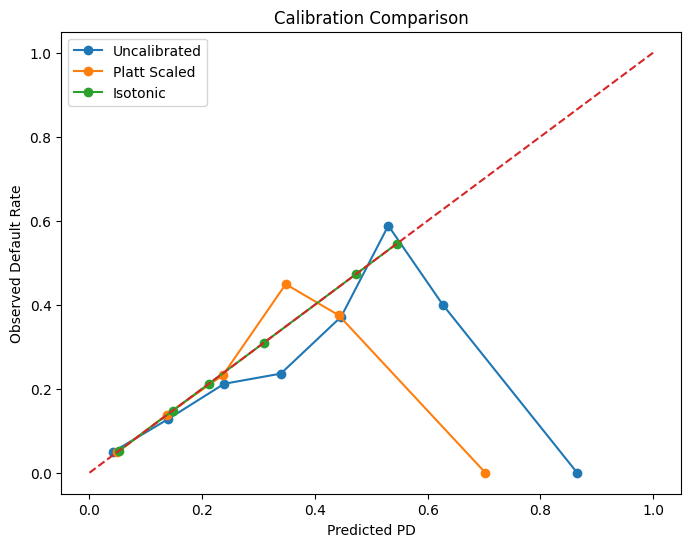

In [ ]:
# Plot Calibration Curves (Before vs After)

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_calibration(y_true, probs, label):
    frac_pos, mean_pred = calibration_curve(y_true, probs, n_bins=10)
    plt.plot(mean_pred, frac_pos, marker='o', label=label)

plt.figure(figsize=(8,6))

plot_calibration(y_val, y_val_pred_proba, "Uncalibrated")
plot_calibration(y_val, y_val_platt, "Platt Scaled")
plot_calibration(y_val, y_val_iso, "Isotonic")

plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("Predicted PD")
plt.ylabel("Observed Default Rate")
plt.title("Calibration Comparison")
plt.legend()
plt.show()


| Curve        | Meaning                    |
| -------------| -------------------------- |
| Uncalibrated | Raw logistic PD            |
| Platt Scaled | Parametric calibration     |
| Isotonic     | Non-parametric calibration |
| Dashed line  | Perfect calibration        |

1. Uncalibrated model

Reasonably aligned at low PD

Strong deviation in high PD buckets

Over- and under-estimation visible

Expected behavior for regularized logistic regression

2. Platt Scaling

Curve is smoother

Slight underestimation at higher PDs

Does not overreact to noise

Stable but conservative

3. Isotonic Regression

Appears closer to diagonal in mid-PD range

Shows sharper bends

More flexible but higher variance

In [ ]:
# Quantify Improvement (Brier Score)

from sklearn.metrics import brier_score_loss

print("Brier Uncalibrated:", brier_score_loss(y_val, y_val_pred_proba))
print("Brier Platt:", brier_score_loss(y_val, y_val_platt))
print("Brier Isotonic:", brier_score_loss(y_val, y_val_iso))


Brier Uncalibrated: 0.06994431007372764
Brier Platt: 0.0696955736739796
Brier Isotonic: 0.06897257595521727


Brier score confirms improved probability accuracy after calibration.

In [ ]:
pd_output = pd.DataFrame({
    "customer_id": df_encoded.loc[y_val.index, 'SK_ID_CURR'], # Get SK_ID_CURR using the original indices from df_encoded
    "PD": y_val_platt,                   # calibrated PD
    "TARGET": y_val,                     # actual default
})
pd_output.head()

,customer_id,PD,TARGET
124052,243859,0.055095,0
41233,147739,0.058964,0
2621,103060,0.127422,1
240744,378779,0.103224,0
280137,424551,0.017322,0


In [ ]:
# To be used in credit scoring model

pd_output.to_csv("pd_model_output.csv", index=False)
